In [1]:
# import gdown
# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
# import os
# import pyro
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
import re
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
from datetime import datetime
import time
import toolz
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from toolz import groupby, count, reduce, reduceby, countby, identity
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
from scipy import stats
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmvae16 as M16
import gmmvaeBeta00 as Mb0
import gmmTraining as Train

print(torch.cuda.is_available())

#plt.ion()
#sc.settings.verbosity = 3
#sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [2]:
adata = sc.read_h5ad("./data/scgen/scGen_datasets/train_study.h5ad")
bdata = sc.read_h5ad("./data/scgen/scGen_datasets/valid_study.h5ad")
adata.X = adata.X.toarray()
bdata.X = bdata.X.toarray()

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [85]:
adata.n_obs, bdata.n_obs, adata.n_vars
adata.obs

,cell_type,condition,mt_frac,n_counts,n_genes,percent_mito,study
index,,,,,,,
AAACATACCAAGCT-1-stimulated-0,NK cells,stimulated,0.0,1158.0,589,NaN,Kang et al
AAACATACCCCTAC-1-stimulated-0,Dendritic cells,stimulated,0.0,1722.0,795,NaN,Kang et al
AAACATACCCGTAA-1-stimulated-0,CD4 T cells,stimulated,0.0,1360.0,585,NaN,Kang et al
AAACATACCCTCGT-1-stimulated-0,B cells,stimulated,0.0,1438.0,732,NaN,Kang et al
AAACATACGAGGTG-1-stimulated-0,CD4 T cells,stimulated,0.0,1233.0,546,NaN,Kang et al
...,...,...,...,...,...,...,...
TTTGACTGGCGGAA-1-control-0,CD8 T cells,control,0.0,2503.0,821,NaN,Kang et al
TTTGACTGTCGTAG-1-control-0,CD14+ Monocytes,control,0.0,3696.0,1101,NaN,Kang et al
TTTGACTGTTACCT-1-control-0,CD14+ Monocytes,control,0.0,2108.0,629,NaN,Kang et al


In [51]:
cdata = sc.read_h5ad("./data/scgen/scGen_datasets/valid_pbmc.h5ad")
ddata = sc.read_h5ad("./data/scgen/scGen_datasets/train_zheng.h5ad")
cdata.X = cdata.X.toarray()
ddata.X = ddata.X.toarray()
cdata.n_obs, ddata.n_obs, cdata.n_vars, ddata.n_vars

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


(1975, 2623, 6998, 7000)

In [32]:
adata.obs["study"]

index
AAACATACCAAGCT-1-stimulated-0    Kang et al
AAACATACCCCTAC-1-stimulated-0    Kang et al
AAACATACCCGTAA-1-stimulated-0    Kang et al
AAACATACCCTCGT-1-stimulated-0    Kang et al
AAACATACGAGGTG-1-stimulated-0    Kang et al
                                    ...    
TTTGACTGGCGGAA-1-control-0       Kang et al
TTTGACTGTCGTAG-1-control-0       Kang et al
TTTGACTGTTACCT-1-control-0       Kang et al
TTTGCATGCTTCGC-1-control-0       Kang et al
TTTGCATGGTCCTC-1-control-0       Kang et al
Name: study, Length: 14893, dtype: category
Categories (1, object): ['Kang et al']

In [33]:
adata.n_obs + bdata.n_obs + cdata.n_obs

18868

In [34]:
cdata.obs["cell_type"]

index
TGCTGAGATGCTAG-1-control       FCGR3A+Mono
CAGACTGACAATCG-1-control              CD4T
GTTGGATGCTTAGG-1-control       FCGR3A+Mono
TTCAAGCTAGCACT-1-control         CD14+Mono
ACCGAAACATTGGC-1-stimulated             NK
                                  ...     
GAGTGTTGCACACA-1-stimulated              B
GACCTCACAGATCC-1-control                NK
GCGTAATGGGTAAA-1-stimulated           CD4T
TACATAGAGAAGGC-1-stimulated           CD4T
CCAGCTACCCGTTC-1-control                 B
Name: cell_type, Length: 1975, dtype: category
Categories (7, object): ['CD4T', 'CD14+Mono', 'B', 'CD8T', 'NK', 'FCGR3A+Mono', 'Dendritic']

In [45]:
ddata.obs["cell_type"]

index
AAACATACAACCAC-1-1        CD4 T cells
AAACATTGAGCTAC-1-1            B cells
AAACATTGATCAGC-1-1        CD4 T cells
AAACCGTGCTTCCG-1-1    CD14+ Monocytes
AAACCGTGTATGCG-1-1           NK cells
                           ...       
TTTCGAACTCTCAT-1-1    CD14+ Monocytes
TTTCTACTGAGGCA-1-1            B cells
TTTCTACTTCCTCG-1-1            B cells
TTTGCATGAGAGGC-1-1            B cells
TTTGCATGCCTCAC-1-1        CD4 T cells
Name: cell_type, Length: 2623, dtype: category
Categories (7, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells']

In [35]:
ddata.obs["study"]

index
AAACATACAACCAC-1-1    Zheng et al
AAACATTGAGCTAC-1-1    Zheng et al
AAACATTGATCAGC-1-1    Zheng et al
AAACCGTGCTTCCG-1-1    Zheng et al
AAACCGTGTATGCG-1-1    Zheng et al
                         ...     
TTTCGAACTCTCAT-1-1    Zheng et al
TTTCTACTGAGGCA-1-1    Zheng et al
TTTCTACTTCCTCG-1-1    Zheng et al
TTTGCATGAGAGGC-1-1    Zheng et al
TTTGCATGCCTCAC-1-1    Zheng et al
Name: study, Length: 2623, dtype: category
Categories (1, object): ['Zheng et al']

In [39]:
ddata.n_vars

7000

In [66]:
ddata.X
ddata.X.mean()
adata.X.mean()
cdata.X.mean()
foo = ad.concat([adata, ddata], label="set", join="inner",)

In [67]:
foo

AnnData object with n_obs × n_vars = 17516 × 7000
    obs: 'cell_type', 'condition', 'mt_frac', 'n_counts', 'n_genes', 'percent_mito', 'study', 'set'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

In [68]:
foo.X.var(), adata.X.var()

(0.06431938, 0.0644765)

In [89]:
enc_labels = LabelEncoder()
labels = enc_labels.fit_transform(adata.obs["cell_type"],)
labels = F.one_hot(torch.tensor(labels)).float()
enc_conds = LabelEncoder()
conditions = enc_conds.fit_transform(adata.obs["condition"],)
conditions = F.one_hot(torch.tensor(conditions)).float()
data = torch.tensor(adata.X)

test_enc_labels = LabelEncoder()
test_labels = test_enc_labels.fit_transform( bdata.obs["cell_type"],)
test_labels = F.one_hot(torch.tensor(test_labels)).float()
test_enc_conds = LabelEncoder()
test_conditions = test_enc_conds.fit_transform(bdata.obs["condition"],)
test_conditions = F.one_hot(torch.tensor(test_conditions)).float()
test_data = torch.tensor(bdata.X)

z_enc_labels = LabelEncoder()
z_labels = z_enc_labels.fit_transform(ddata.obs["cell_type"],)
z_labels = F.one_hot(torch.tensor(z_labels)).float()
z_enc_conds = LabelEncoder()
z_conditions = z_enc_conds.fit_transform(ddata.obs["condition"],)
#z_conditions = z_enc_conds.fit_transform(["control", "stimulated"],)
z_conditions = F.one_hot(torch.tensor(z_conditions), num_classes=2).float()
z_data = torch.tensor(ddata.X)

In [90]:
z_conditions

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [79]:
model = Mb0.VAE_AE_TypeB1500vC(
    nx=bdata.n_vars,
    nz=18,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_z=False,
    nc1=2,
    learned_prior=False,
)
model.apply(init_weights)
print(model.__class__)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
#x, y, c = data_loader.__iter__().next()


<class 'gmmvaeBeta00.VAE_AE_TypeB1500vC'>


In [80]:
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=35,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        #test_accuracy=True,
        )

epoch's lr =  0.001
epoch 0
training phase
rec: 1355.60205078125
loss_z: 14.204154968261719
total_loss: 1369.80615234375

epoch's lr =  0.001
epoch 0
training phase
rec: 205.9843292236328
loss_z: 6.1288628578186035
total_loss: 212.11318969726562

epoch's lr =  0.001
epoch 0
training phase
rec: 198.28684997558594
loss_z: 6.514610290527344
total_loss: 204.80145263671875

epoch's lr =  0.0001
epoch 0
training phase
rec: 206.11424255371094
loss_z: 6.844698429107666
total_loss: 212.9589385986328

epoch's lr =  1e-05
epoch 0
training phase
rec: 199.89193725585938
loss_z: 7.432123184204102
total_loss: 207.32406616210938

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


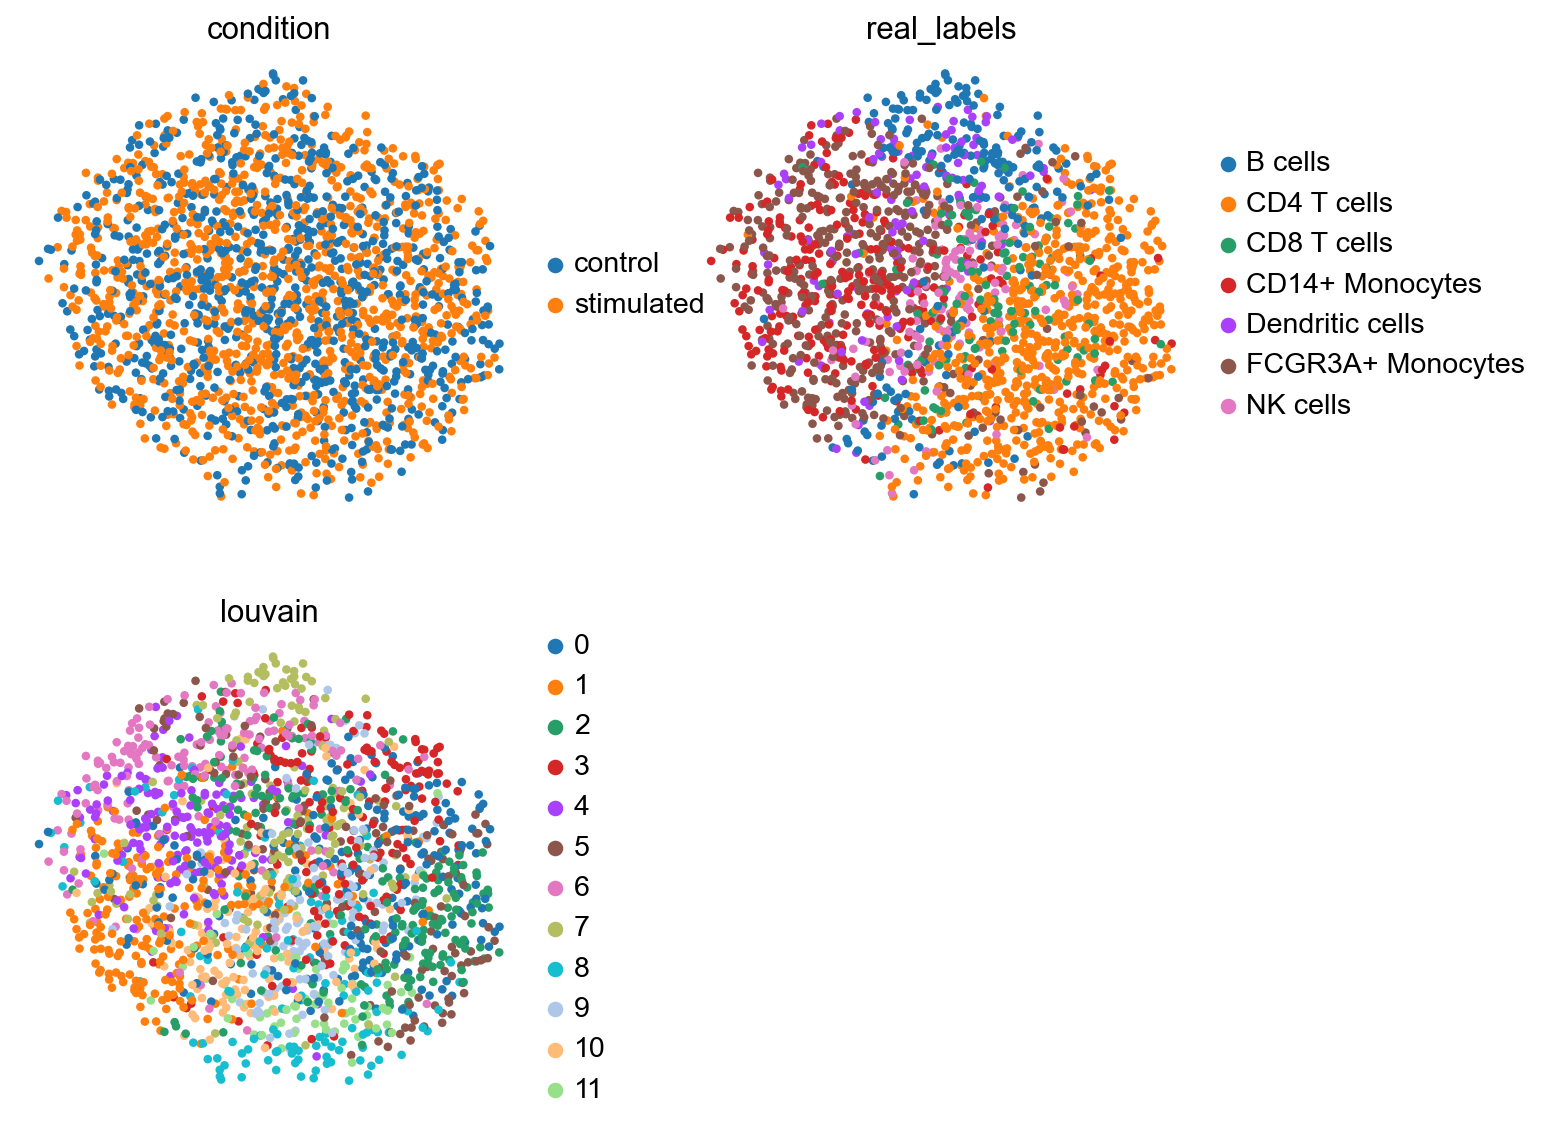

In [83]:
output = model(test_data, cond1=test_conditions )
#bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
#bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#bdata.obsm["z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)
sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


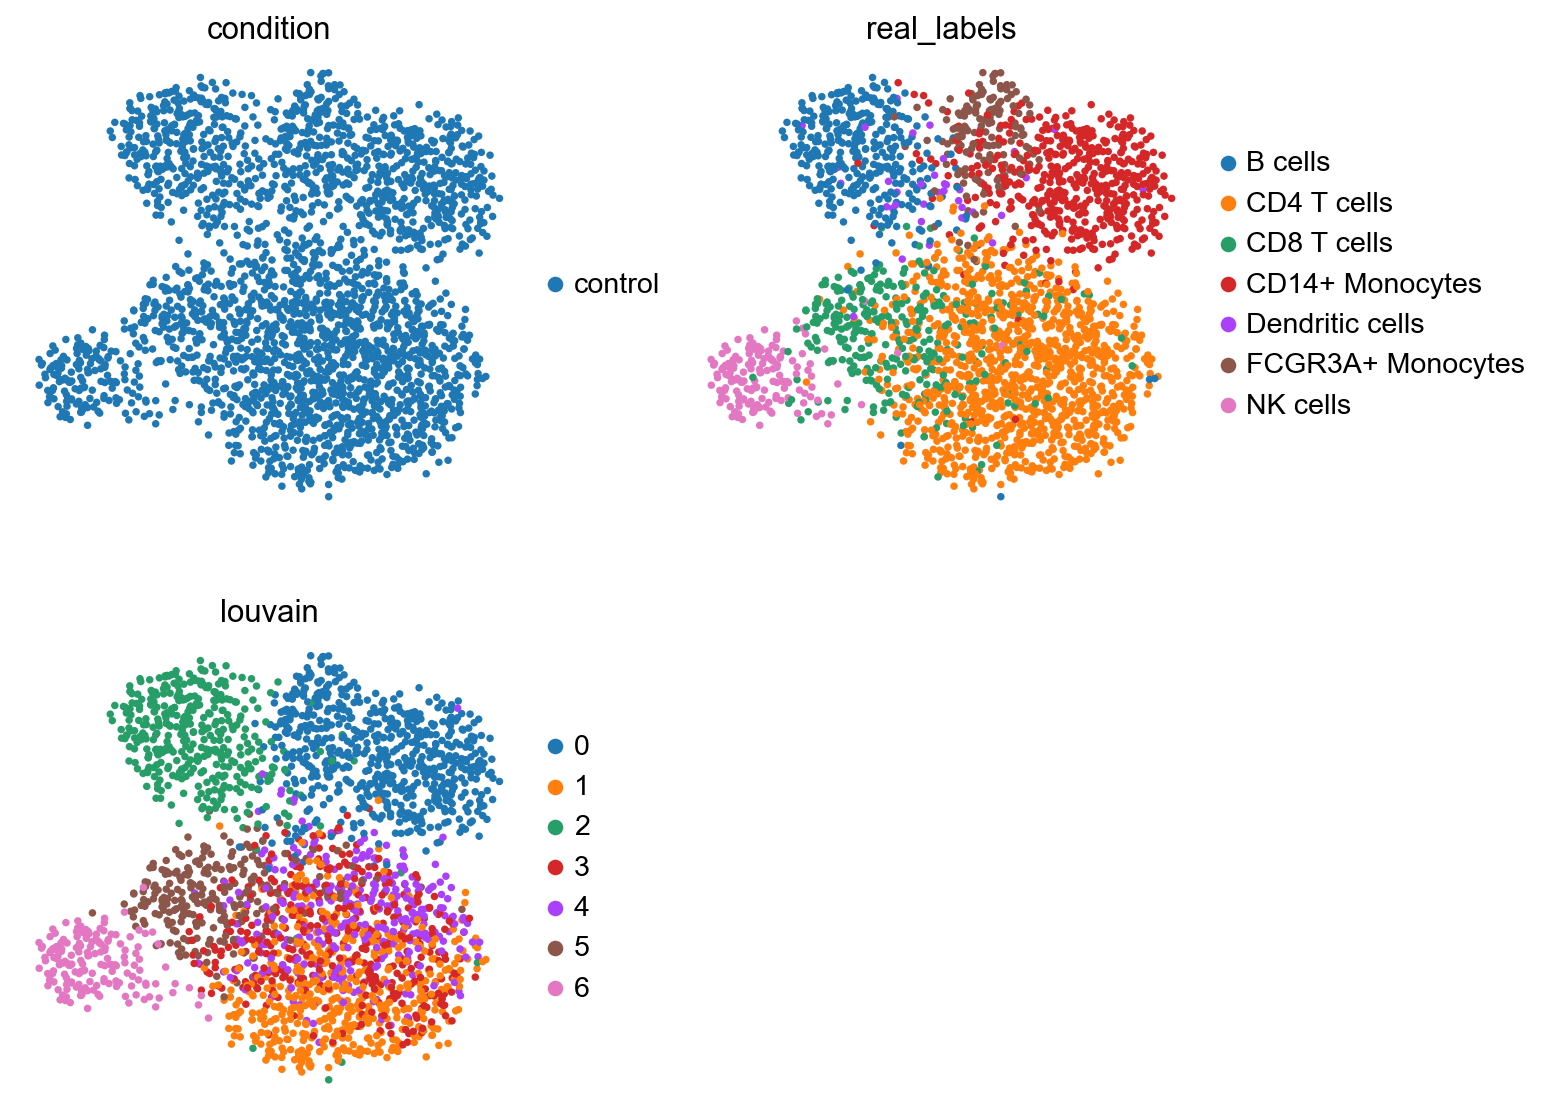

In [91]:
output = model(z_data, cond1=z_conditions)
#bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
#bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#bdata.obsm["z"] = output["mu_z"].detach().numpy()
ddata.obsm["z"] = output["z"].detach().numpy()
ddata.obs["real_labels"] = z_enc_labels.inverse_transform(
        z_labels.argmax(-1))
sc.pp.neighbors(ddata,use_rep="z")
sc.tl.umap(ddata, )
sc.tl.louvain(ddata,)
sc.pl.umap(ddata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )


In [100]:
#ctrlMaerker = adata.obs["condition"] == "control"
cd4Marker_d = ddata.obs["cell_type"] == "CD4 T cells"
#xdata = adata[ctrlMaerker & cd4Marker].copy()
#xdata.obs
model.cpu()
model.eval()
simOutput = model(
    input=z_data[cd4Marker_d],
    y=z_labels[cd4Marker_d],
    cond1=1-z_conditions[cd4Marker_d],
)

In [123]:
#xdata = adata[adata.obs["condition"] == "stimulated"].copy()
xdata = adata[adata.obs["cell_type"] == "CD4 T cells"].copy()
xdata.obs
ydata = ddata[ddata.obs["cell_type"] == "CD4 T cells"].copy()
#ydata.obs["sim"] = ["sim_stim"]*ydata.n_obs
ydata.obs["condition"] = ["sim_stim"]*ydata.n_obs
yydata = ddata[ddata.obs["cell_type"] == "CD4 T cells"].copy()
yydata.obs["condition"] = ["ctrl_real"]*yydata.n_obs
#yydata.obs["sim"] = ["ctrl"]*ydata.n_obs
#xdata.obs["sim"] = ["stim"]*xdata.n_obs
#ydata.obs
#xdata.obs
ydata.X = simOutput['rec'].detach().abs().numpy()
ydata.obsm["z"] = simOutput["z"].detach().numpy()
ydata.obsm["mu_z"] = simOutput["mu_z"].detach().numpy()
#ydata.obsm["mu_w"] = simOutput["mu_w"].detach().numpy()
#cdata.obsm["w"] = simOutput["w"].detach().numpy()

In [124]:
zdata = ad.concat([xdata, ydata, yydata], label="set", join="inner",)
zdata.obs


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


,cell_type,condition,mt_frac,n_counts,n_genes,percent_mito,study,set
index,,,,,,,,
AAACATACCCGTAA-1-stimulated-0,CD4 T cells,stimulated,0.0,1360.0,585,NaN,Kang et al,0
AAACATACGAGGTG-1-stimulated-0,CD4 T cells,stimulated,0.0,1233.0,546,NaN,Kang et al,0
AAACATACGTCGTA-1-stimulated-0,CD4 T cells,stimulated,0.0,1369.0,582,NaN,Kang et al,0
AAACATTGACTTTC-1-stimulated-0,CD4 T cells,stimulated,0.0,1996.0,615,NaN,Kang et al,0
AAACATTGTGTGGT-1-stimulated-0,CD4 T cells,stimulated,0.0,1761.0,792,NaN,Kang et al,0
...,...,...,...,...,...,...,...,...
TTGTAGCTAGCTCA-1-1,CD4 T cells,ctrl_real,NaN,2456.0,933,0.022249,Zheng et al,2
TTTAGCTGATACCG-1-1,CD4 T cells,ctrl_real,NaN,2686.0,887,0.022876,Zheng et al,2
TTTCACGAGGTTCA-1-1,CD4 T cells,ctrl_real,NaN,1998.0,721,0.013261,Zheng et al,2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


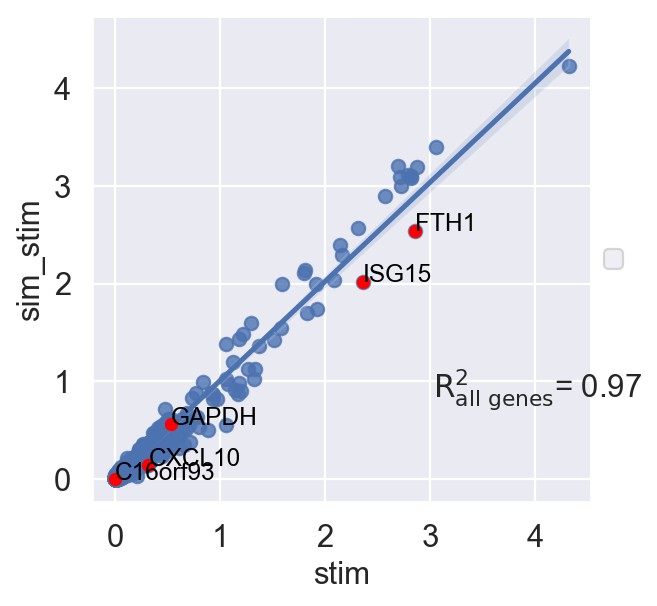

0.9746997090534713

In [125]:
ut.reg_mean_plot(zdata, show=True, condition_key="condition",
                 axis_keys={"x" : "stimulated", "y" : "sim_stim"},
                 labels={"x" : "stim", "y" : "sim_stim"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 #save="Kang_reg_ctrl_resp.png",
                )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


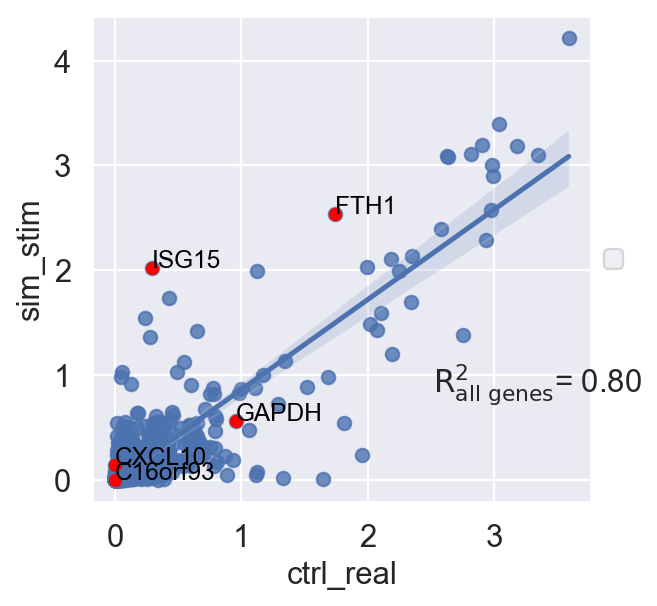

0.7953530053799999

In [126]:
ut.reg_mean_plot(zdata, show=True, condition_key="condition",
                 axis_keys={"x" : "ctrl_real", "y" : "sim_stim"},
                 labels={"x" : "ctrl_real", "y" : "sim_stim"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 #save="Kang_reg_ctrl_resp.png",
                )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


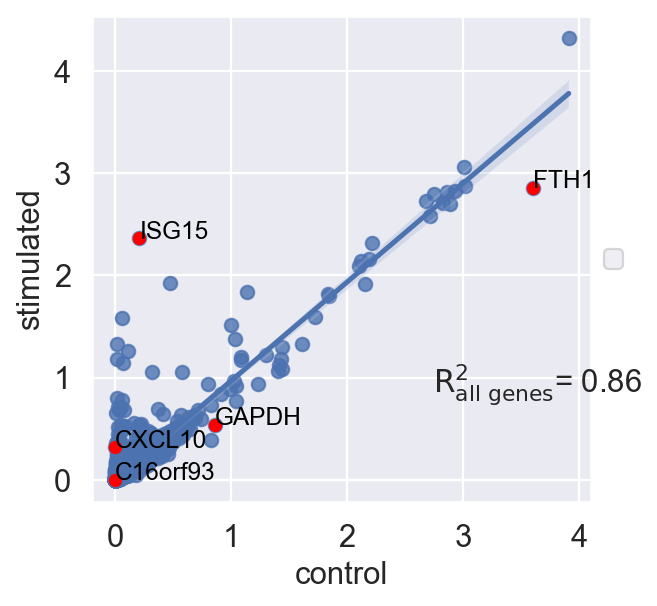

0.8641454106723353

In [127]:
ut.reg_mean_plot(zdata, show=True, condition_key="condition",
                 axis_keys={"x" : "control", "y" : "stimulated"},
                 labels={"x" : "control", "y" : "stimulated"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 #save="Kang_reg_ctrl_resp.png",
                )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


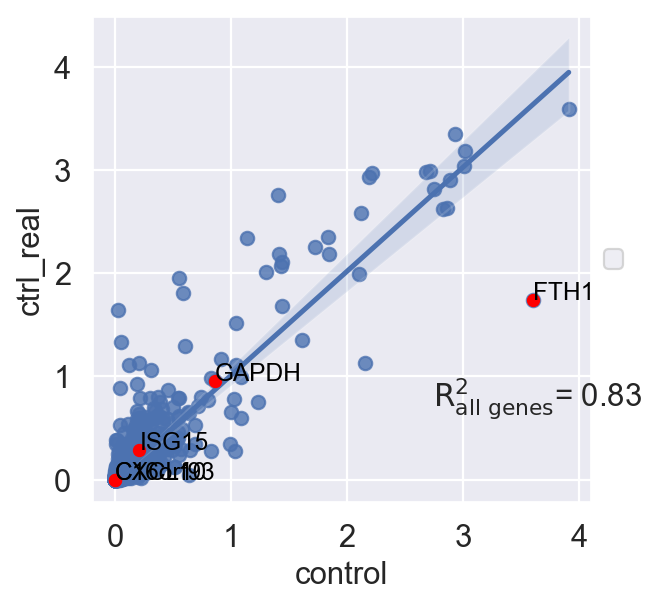

0.8326920370631749

In [128]:
ut.reg_mean_plot(zdata, show=True, condition_key="condition",
                 axis_keys={"x" : "control", "y" : "ctrl_real"},
                 labels={"x" : "control", "y" : "ctrl_real"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 #save="Kang_reg_ctrl_resp.png",
                )

In [130]:
np.unique(zdata.obs["condition"])

array(['control', 'ctrl_real', 'sim_stim', 'stimulated'], dtype=object)

In [139]:
yydata.X.mean()
ydata.X.mean()

0.04982068

In [143]:
ut.saveModelParameters(
        model,
        "./results/Kang_cvae_pt4_xzC" + str(datetime.timestamp(datetime.now())) + "model_params.pt",
        method="json",
        )
torch.save(
        model.state_dict(),
        "./results/Kang_cvae_pt4_xzC" + str(datetime.timestamp(datetime.now())) + "model_state.pt",
        )

In [141]:
model.__class__

gmmvaeBeta00.VAE_AE_TypeB1500vC

## Generation

In [147]:
reload(Mb0)
reload(ut)
model = Mb0.VAE_Dirichlet_GMM_TypeB1602xzCv2(
    nx=adata.timeStamps,
    nz=18,
    nw=18,
    nclasses=labels.shape[1],
    concentration=1e0,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_w=True,
    restrict_z=True,
    nc1=conditions.shape[1],
    learned_prior=False,
    #learned_prior=True,
    positive_rec=True,
)
model.apply(init_weights)
print(model.__class__)

True
<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xzCv2'>


In [149]:
Train.trainSemiSuperLoopCond(
        model,
        data_loader,
        data_loader,
        data_loader,
        #labeled_loader,
        #unlabeled_loader,
        #test_loader,
        num_epochs=50,
        report_interval=55,
        lrs = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        do_unlabeled=True,
        do_validation=True,
        test_accuracy=True,
        )

epoch 0
labeled phase
rec: 820.2740478515625
loss_z: 38.031646728515625
loss_w: 10.458365440368652
loss_cluster: -0.4168958067893982
loss_d: 4.910338878631592
loss_y_alt: 2.922762870788574
loss_y_alt2: 2.4572572708129883
total_loss: 879.054443359375
num_clusters: 5

[0. 2. 5. 0. 2. 2. 0.] 
 0.3791604806588159 
 [0.25       0.5        0.73333333 0.2        0.29411765 0.35849057
 0.31818182]
0.390625 

unlabeled phase
rec: 433.762451171875
loss_z: 19.786941528320312
loss_w: 8.317663192749023
loss_cluster: -0.6158565282821655
loss_d: 2.860321283340454
loss_y_alt: 1.1864798069000244
loss_y_alt2: 0
total_loss: 465.9138488769531
num_clusters: 6

eval phase
rec: 341.06243896484375
loss_z: 10.20467472076416
loss_w: 5.184281349182129
loss_cluster: -0.8202416300773621
loss_d: 1.4634400606155396
loss_y_alt: 1.408449411392212
loss_y_alt2: 0
total_loss: 359.32330322265625
num_clusters: 5
ce loss: -1.1608002185821533

done training
epoch 0
labeled phase
rec: 202.57980346679688
loss_z: 3.819539070129

In [150]:
ut.saveModelParameters(
        model,
        "./results/Kang_ss_xzCv2_pt4" + str(datetime.timestamp(datetime.now())) + "model_params.pt",
        method="json",
        )
torch.save(
        model.state_dict(),
        "./results/Kang_ss_xzCv2_pt4" + str(datetime.timestamp(datetime.now())) + "model_state.pt",
        )

In [151]:
ut.saveModelParameters(
        model,
        "./results/Kang_ss_xzCv2_pt4" + ut.randomString() +  ut.timeStamp() + "model_params.pt",
        method="json",
        )
torch.save(
        model.state_dict(),
        "./results/Kang_ss_xzCv2_pt4" + ut.randomString() + ut.timeStamp() + "model_state.pt",
        )

In [165]:
bdata.obs["label"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
adata.obs["label"] = enc_labels.inverse_transform(
        labels.argmax(-1))

In [168]:
model.cpu()
model.eval()
output = model(
    input=test_data,
    y=test_labels,
    cond1=test_conditions,
)
bdata.obs["predict"] = test_enc_labels.inverse_transform(
    output["q_y"].argmax(-1).detach().numpy(),
)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predict' as categorical


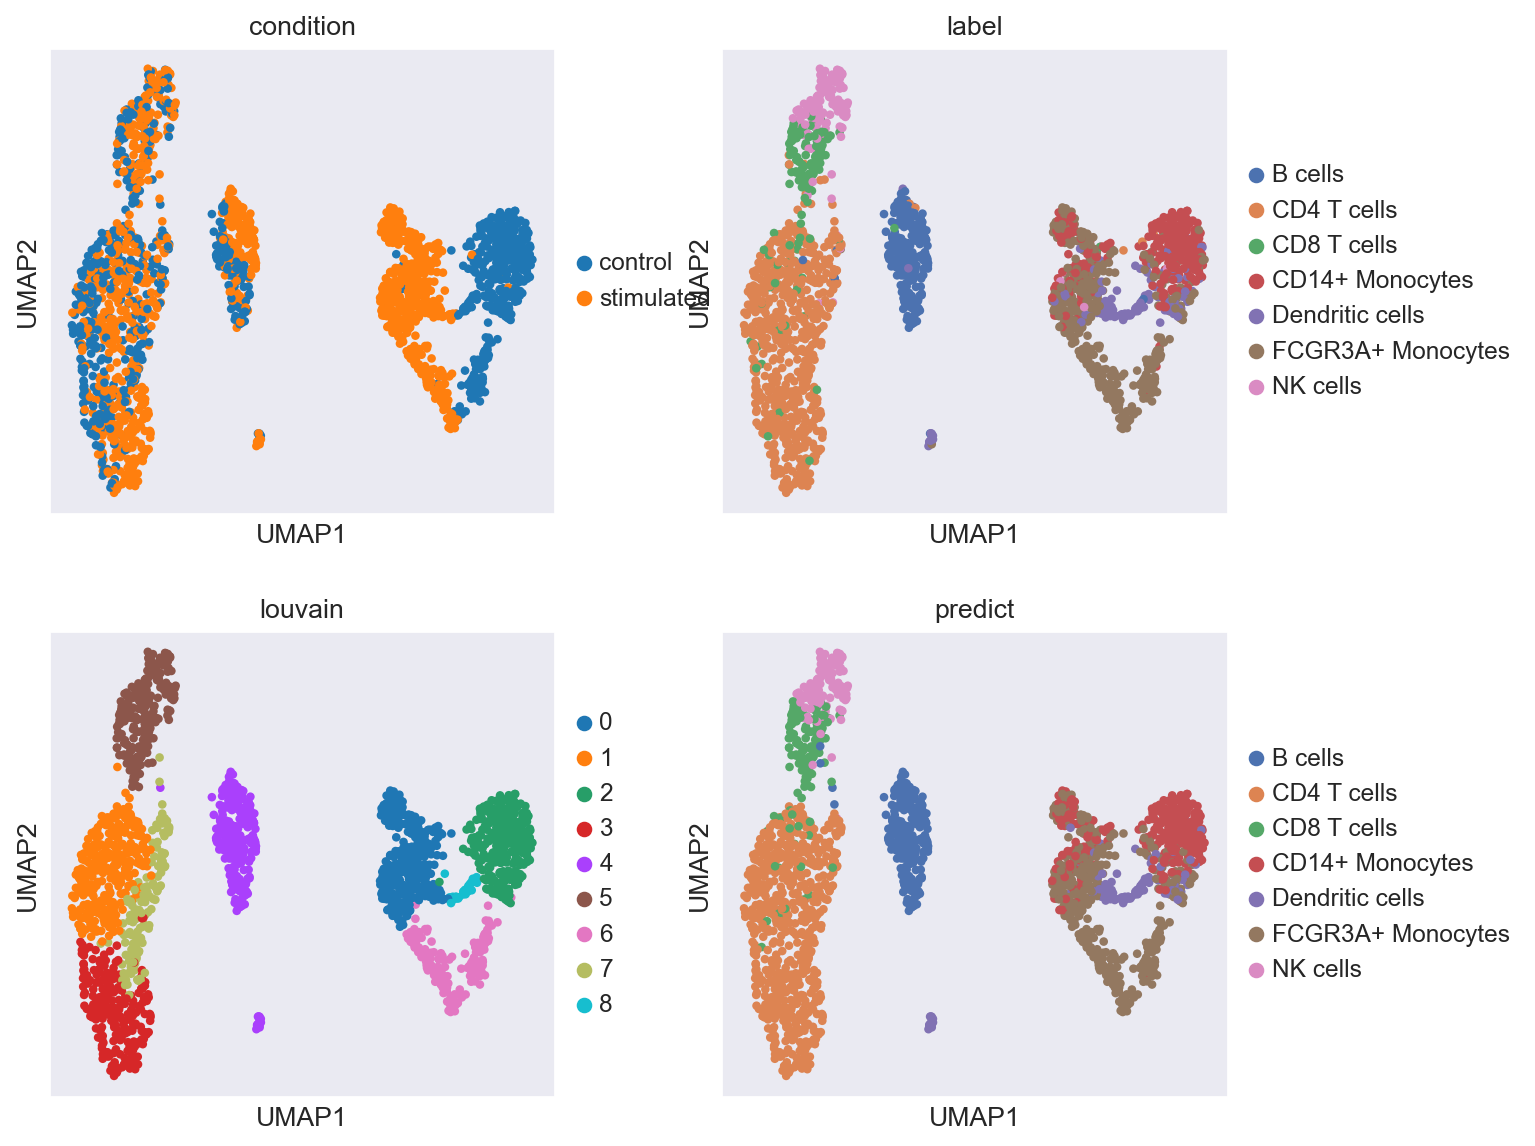

In [169]:
sc.pp.neighbors(bdata, use_rep="mu_z")
#sc.pp.neighbors(bdata, use_rep="mu_w",)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)
sc.pl.umap(bdata, ncols=2, 
           color=[
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           #save="_test_set_semisupervised_Kang_w_space_xzCvs.png",
           #show=True,
           #ax=ax,
          )

In [191]:
w = torch.randn(80, model.nw)
c = torch.zeros(80,2)
c[:40,0] = 1
c[40:,1] = 1
wc = torch.cat([w,c], dim=1)
z = model.Pz(
    torch.cat([w,c], dim=1),)[:,:,:model.nz]

In [215]:
z.shape, c.unsqueeze(1).shape
#torch.cat([z,c.unsqueeze(1)], dim=-1 )
w.shape
c.shape
wc.shape
c
model.nclasses
z.shape
cs = c.unsqueeze(1)
cs=cs.expand_as(z[:,:,:2])
z.shape, cs.shape
cs[39:41]
zcs = torch.cat([z,cs],dim=-1).reshape(80*7,20)
zcs.shape

torch.Size([560, 20])

In [217]:
model.eval()
rec = model.Px(zcs)
#rec = model.Px(
#    torch.cat([z,cs], dim=-1),)
rec.shape

torch.Size([560, 7000])

In [225]:
new_pred = model.Qy(
    torch.cat([z.reshape(-1,18),rec,cs.reshape(-1,2)], dim=-1),)

In [233]:
new_pred.detach().argmax(-1)
list(enc_labels.classes_) *2

['B cells',
 'CD14+ Monocytes',
 'CD4 T cells',
 'CD8 T cells',
 'Dendritic cells',
 'FCGR3A+ Monocytes',
 'NK cells',
 'B cells',
 'CD14+ Monocytes',
 'CD4 T cells',
 'CD8 T cells',
 'Dendritic cells',
 'FCGR3A+ Monocytes',
 'NK cells']

In [235]:
gdata = sc.AnnData(
    X = rec.detach().numpy(),
    obs = {
        "condition" : 40*7*["control"] + 40*7*["stimulated"],
        "sim" : 40*7*["gen_control"] + 40*7*["gen_stimulated"],
        #"label" : 40 * ["(generated control) CD14+"] + 40*["(generated response) CD14+"],
        #"label" : 80 * ["(generated) CD14+"],
        "label" : 80 * list(enc_labels.classes_) ,
    },
    obsm = {
        "z" : z.reshape(80*7,-1).detach().numpy(),
        "mu_z" : z.reshape(80*7,-1).detach().numpy(),
        #"w" : w.detach().numpy(),
    },
    var = {
        "var_names" : bdata.var_names,
    }
)

In [245]:
gdata.obs['label']
bdata.obs["label"]
bdata.obs["sim"] = bdata.obs["condition"].copy()
bdata.obs
xdata = sc.concat([bdata,gdata],join="inner", label="set",)

In [248]:
sc.pp.neighbors(xdata, use_rep="mu_z")
sc.tl.umap(xdata,)
sc.tl.louvain(xdata,)

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'label' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a 

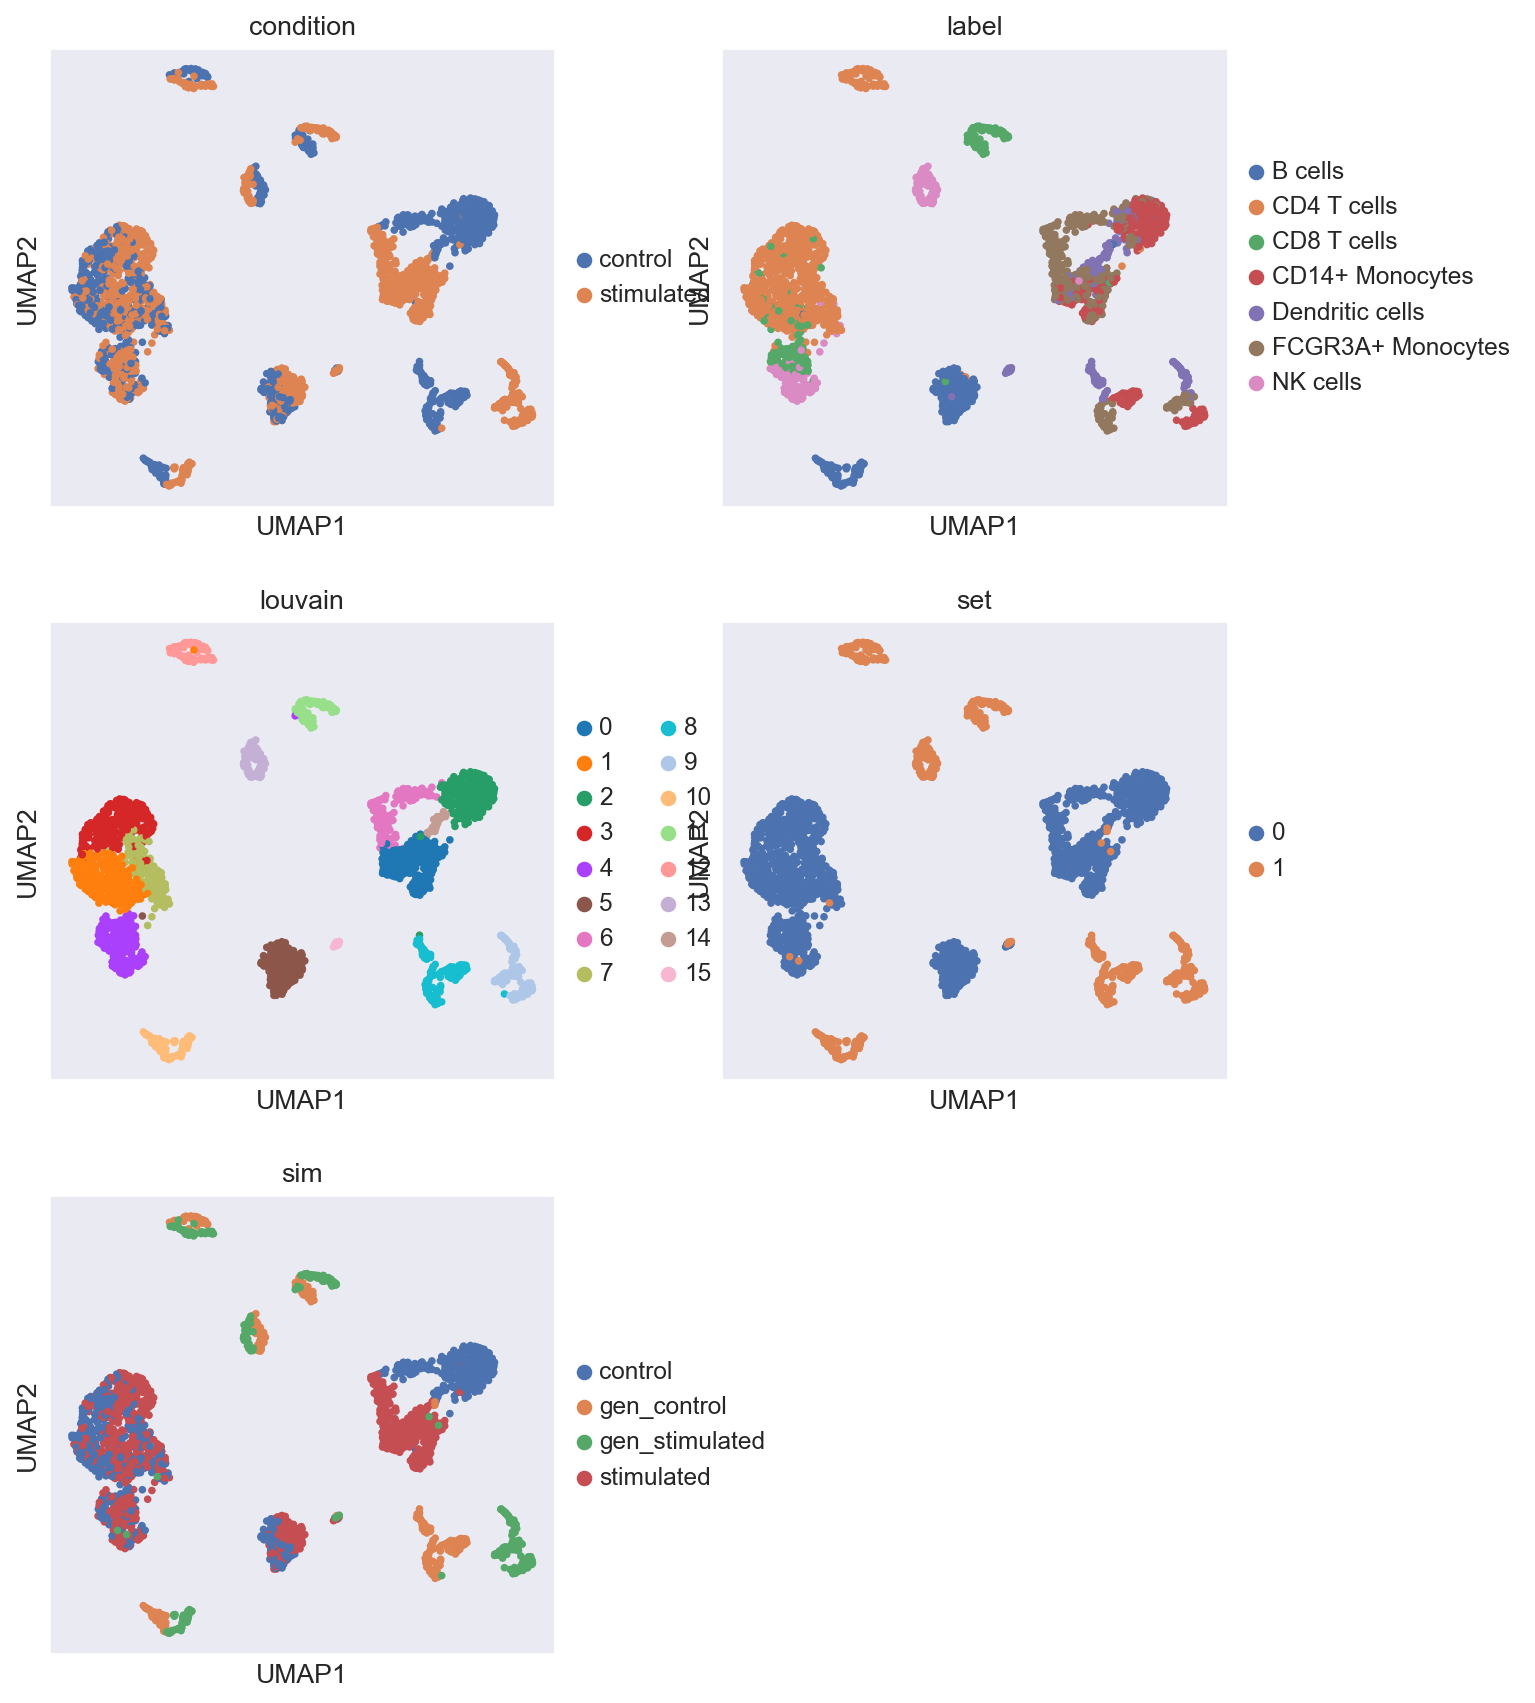

In [250]:
sc.pl.umap(xdata, ncols=2, 
           color=[
               "condition",
               "label",
               "louvain",
               "set",
               "sim",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           #save="_test_set_semisupervised_Kang_w_space_xzCvs.png",
           #show=True,
           #ax=ax,
          )


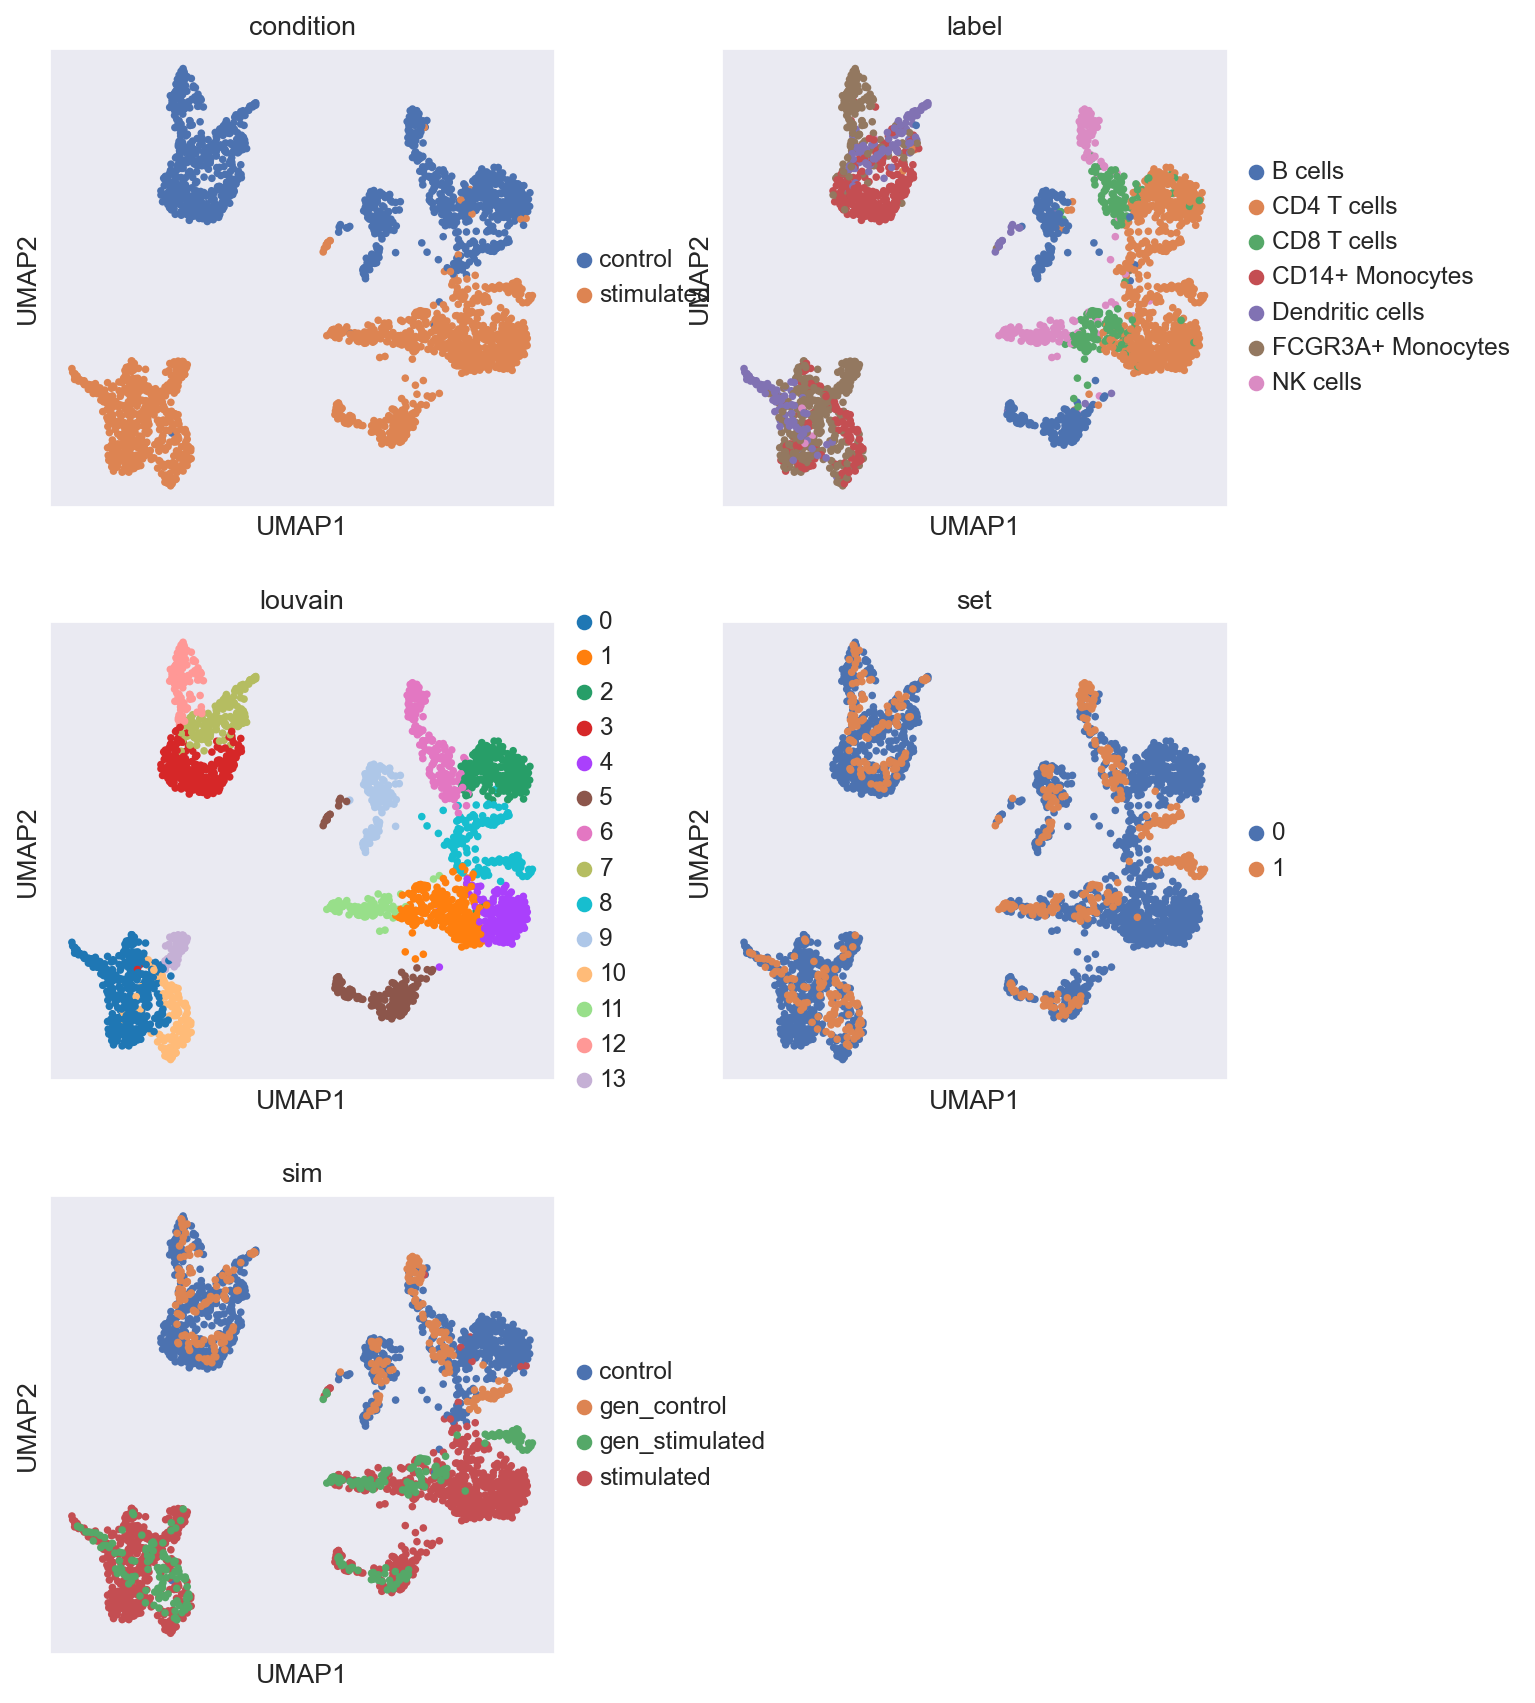

In [251]:
sc.pp.pca(xdata,)
sc.pp.neighbors(xdata, )
sc.tl.umap(xdata,)
sc.tl.louvain(xdata,)
sc.pl.umap(xdata, ncols=2, 
           color=[
               "condition",
               "label",
               "louvain",
               "set",
               "sim",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           #save="_test_set_semisupervised_Kang_w_space_xzCvs.png",
           #show=True,
           #ax=ax,
          )

In [270]:
new_data = torch.cat([test_data, rec], dim=0)
new_conds = torch.cat((test_conditions, cs.reshape(80*7,-1)), dim=0)
#cs.shape
l = torch.eye(model.nclasses,).tile(80,1)
new_labels = torch.cat([test_labels, l],dim=0)

In [272]:
output=model(new_data, y=new_labels, cond1=new_conds)
xdata.obsm["new_z"] = output["mu_z"].detach().numpy()
xdata.obs["new_predict"] = test_enc_labels.inverse_transform(
    output["q_y"].argmax(-1).detach().numpy(),
)

In [275]:
sc.pp.neighbors(xdata, use_rep="new_z")
sc.tl.umap(xdata,)
sc.tl.louvain(xdata,)

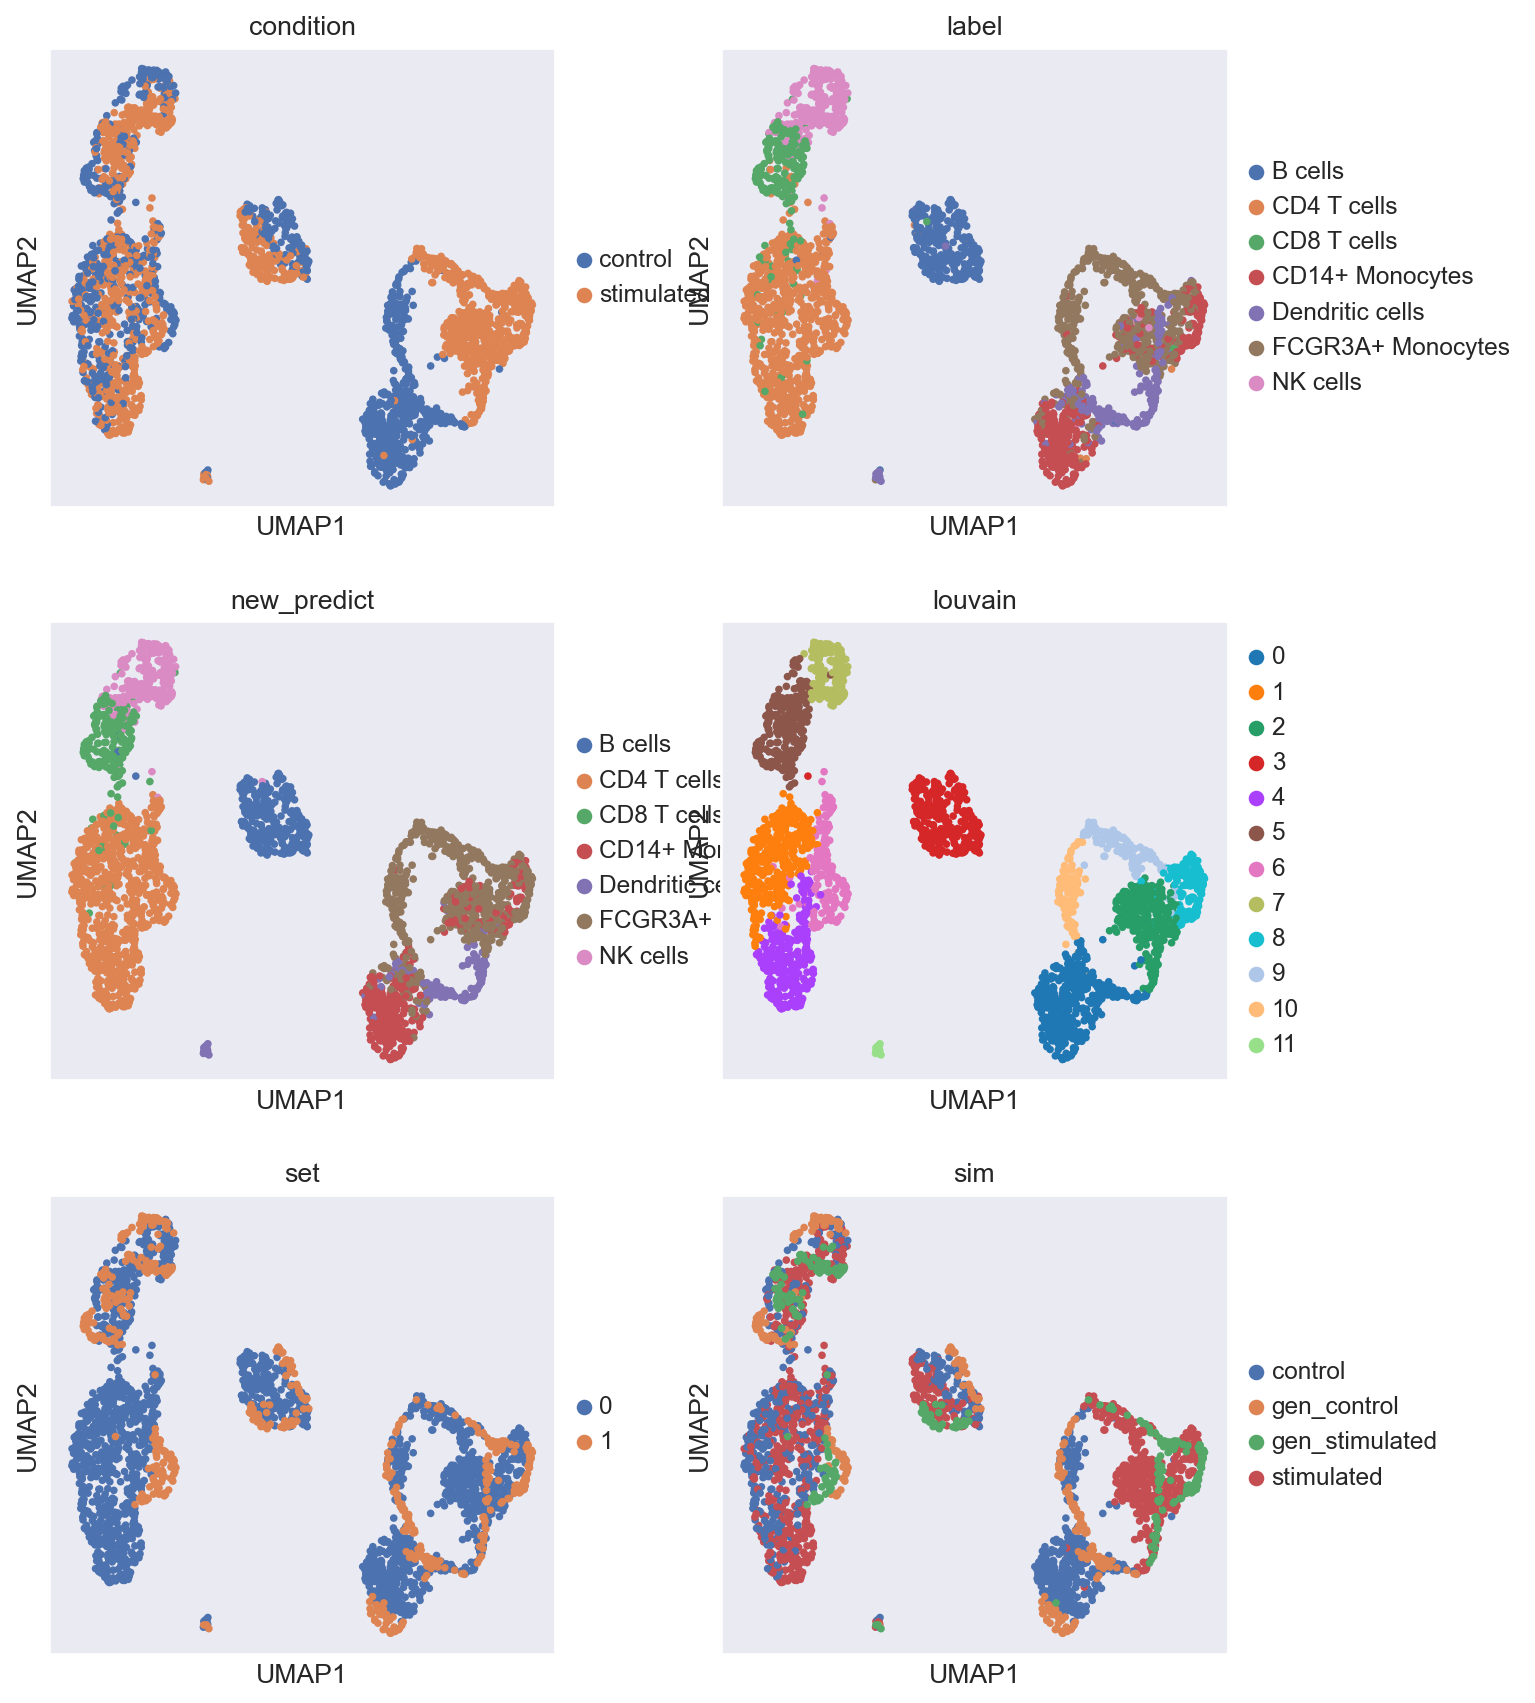

In [276]:
sc.pl.umap(xdata, ncols=2, 
           color=[
               "condition",
               "label",
               "new_predict",
               "louvain",
               "set",
               "sim",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           #save="_test_set_semisupervised_Kang_w_space_xzCvs.png",
           #show=True,
           #ax=ax,
          )

In [279]:
output=model(test_data, y=test_labels, cond1=test_conditions)
rec = output["rec"].detach()
torch.cosine_similarity(test_data, rec).mean()

tensor(0.7502)

In [280]:
model.__class__

gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xzCv2